In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fcsparser
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd
import pickle
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

import isde
import isde.estimators

from fde import *
from gaussian_mixture_cv import *

exp_name = "Levine32_N20000"

X = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/X.npy")
axes = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/axes.npy")

def logdensity_from_partition(X_grid, X_eval, partition, by_subsets):
    logdensity_isde = np.zeros(X_eval.shape[0])
    for S in partition:
        loc_d = len(S)
        loc_h = by_subsets[tuple(S)]['params']['bandwidth']
        logdensity_isde += isde.estimators.GaussianKDE(bandwidth=loc_h).score_samples(grid_points=X_grid[:, S], eval_points=X_eval[:, S])

    return np.ma.masked_invalid(logdensity_isde)

In [3]:
#Load

by_subsets = pickle.load(open("/home/louis/Projets/ISDE/data/" + exp_name + "/by_subets", "rb"))
X_train = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/X_train.npy")
X_validation = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/X_validation.npy")
graph_FDE = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/graoh_FDE.npy")
proportions = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/proportions.npy")
means = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/means.npy")
covariances = np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/covariances.npy")
bandwidth_kde = float(np.load("/home/louis/Projets/ISDE/data/" + exp_name + "/bandwidth_kde.npy"))

In [8]:
#Compute best partition for given k
if exp_name == "Levine32" or exp_name == "Levine32_N20000":
    k = 3
elif exp_name == "Levine13" or exp_name == "Levine13_N20000":
    k = 5
    
partition = isde.find_optimal_partition(scores_by_subsets=by_subsets, max_size=k,
                                        min_size=1, exclude = [], sense='maximize')[0]

In [9]:
M = 20
N_v = 2000

N_valid, d = X_validation.shape
indices = list(range(N_valid))

ll_isdes = []
ll_fdes = []
ll_mixmods = []
ll_kdes = []

for i in range(M):
    np.random.shuffle(indices)
    X_v = X_validation[indices[0:N_v], :]
    
    #KDE
    logdensity_kde = isde.estimators.GaussianKDE(bandwidth=bandwidth_kde).score_samples(grid_points=X_train, eval_points=X_v)
    ll_kdes.append(logdensity_kde.mean())
    
    # ISDE
    logdensity_isde = logdensity_from_partition(X_grid=X_train, X_eval=X_v,
                                                partition=partition, by_subsets=by_subsets)
    
    ll_isdes.append(logdensity_isde.mean())
    
    # Mixmod
    selected_nc = len(proportions)
    density_mixmod = np.zeros(N_v)
    for i in range(selected_nc):
        density_mixmod += proportions[i] * multivariate_normal(mean=means[i], cov=covariances[i]).pdf(X_v)
    
#     ll_mixmods.append( gm.score_samples(X_v).mean() )
    ll_mixmods.append(np.mean(np.log(density_mixmod)))
    
    # FDE
    tmp = np.ma.masked_invalid(logdensity_from_tree(X_train, X_v, graph_FDE, bw_bysubsets=True, by_subsets=by_subsets))
    ll_fdes.append(tmp.mean())

/home/louis/anaconda3/envs/cytometry/lib/python3.9/site-packages/isde/estimators/GaussianKDE.py:68: RuntimeWarning: divide by zero encountered in log
  return np.log( gaussian_kde(grid_points=grid_points, eval_points=eval_points, h=self.bandwidth) )
/home/louis/Projets/ISDE/fde.py:161: RuntimeWarning: invalid value encountered in subtract
  ll -= GaussianKDE(bandwidth=loc_he1).score_samples(eval_points=X_eval[:, [e[1]]], grid_points=X[:, [e[1]]])
/home/louis/Projets/ISDE/fde.py:160: RuntimeWarning: invalid value encountered in subtract
  ll -= GaussianKDE(bandwidth=loc_he0).score_samples(eval_points=X_eval[:, [e[0]]], grid_points=X[:, [e[0]]])


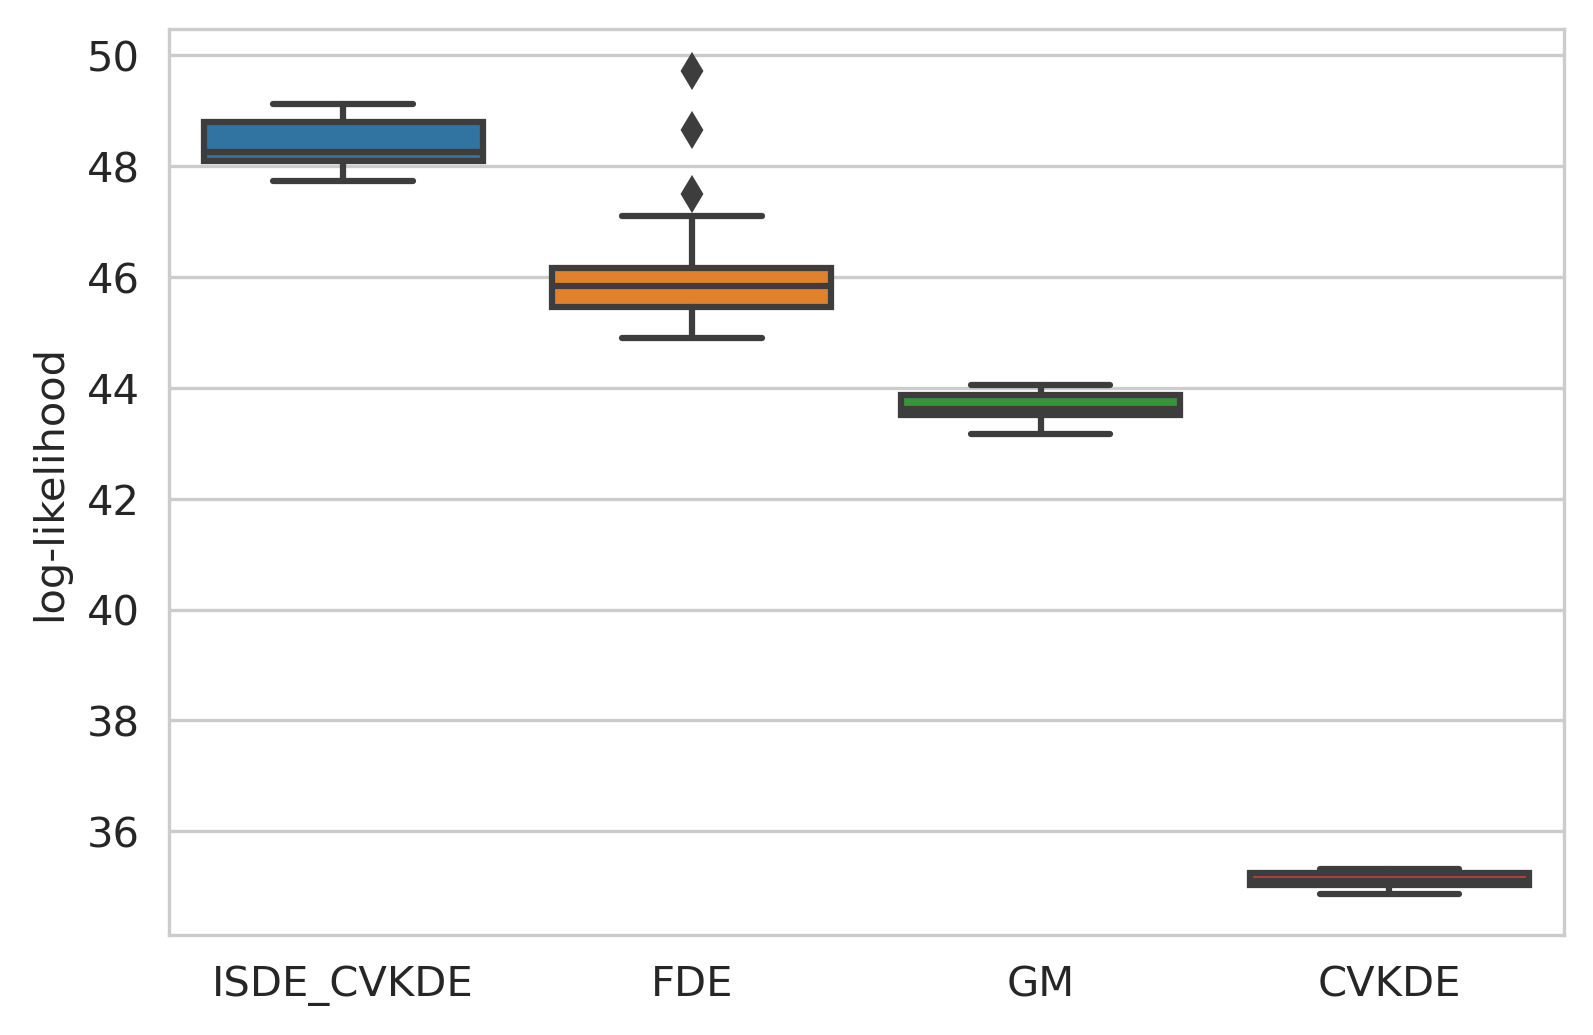

<Figure size 1800x1200 with 0 Axes>

In [10]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


df = pd.DataFrame()
df["ISDE_CVKDE"] = ll_isdes
df["FDE"] = ll_fdes
df["GM"] = ll_mixmods
df["CVKDE"] = ll_kdes
sns.set_style("whitegrid")
ax = sns.boxplot(data=df)
plt.ylabel("log-likelihood")
plt.show()

sns.set_style("whitegrid")
ax = sns.boxplot(data=df)
plt.ylabel("log-likelihood")
plt.savefig("/home/louis/Projets/ISDE/data/" + exp_name + "/results.png")
plt.clf()

In [11]:
partition

[[0, 15],
 [1],
 [10],
 [11, 12, 23],
 [13],
 [14, 17, 22],
 [16],
 [18, 30],
 [19],
 [2],
 [20],
 [21],
 [24],
 [25, 29],
 [26, 31],
 [27],
 [28],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9]]

## First Run

In [2]:
#Split Train/Validation

np.random.seed(42)
N, d = X.shape
indices = np.array(list(range(N)))
np.random.shuffle(indices)
N_train = 5000
if exp_name == "Levine13_N20000" or exp_name == "Levine32_N20000":
    N_train = 23000
X_train = X[indices[0:N_train], :]
X_validation = X[indices[N_train::], :]

In [3]:
#KDE
hs = np.logspace(-3,-1,40)

%time bandwidth_kde = isde.estimators.CVKDE(X_train, params={"hs": hs, "n_fold" : 5})[0].bandwidth

[KeOps] Compiling formula Sum_Reduction(Exp(-((Var(0,32,0)-Var(1,32,1))|(Var(0,32,0)-Var(1,32,1)))),1) ... OK


/home/louis/anaconda3/envs/cytometry/lib/python3.9/site-packages/isde/estimators/GaussianKDE.py:98: RuntimeWarning: divide by zero encountered in log
  scores[h].append(np.mean (np.log( gaussian_kde(grid_points=W_train, eval_points=W_test, h=h))))


CPU times: user 23.2 s, sys: 116 ms, total: 23.3 s
Wall time: 23.3 s


In [4]:
#ISDE

if exp_name == "TBNK":
    m, n = 3000, 2000
    h = 0
    hs = np.logspace(-2,0,30)
    estimator = isde.estimators.CVKDE
    k = 9
    
if exp_name == "Levine13_N20000":
    m, n = 21000, 2000
    h = 0
    hs = np.logspace(-3,-1,30)
    estimator = isde.estimators.Hold_out_KDE
    n_train = 20000
    k = 5
    
if exp_name == "Levine13":
    m, n = 3000, 2000
    h = 0
    hs = np.logspace(-3,-1,30)
    estimator = isde.estimators.CVKDE
    k = 5
    
if exp_name == "Levine32":
    m, n = 3000, 2000
    h = 0.14
    hs = np.logspace(-3,-1,30)
    estimator = isde.estimators.CVKDE
    k = 3
    
if exp_name == "Levine32_N20000":
    m, n = 21000, 2000
    h = 0
    hs = np.logspace(-3,-1,30)
    estimator = isde.estimators.Hold_out_KDE
    n_train = 20000
    k = 3


start = time.time()
by_subsets = isde.ISDE(X=X_train, m=m, n=n, k=k, multidimensional_estimator=estimator, hs=hs, h=h, n_train=n_train,
                       do_optimization=False, verbose=True)
elapsed = time.time() - start

# lls = [by_subsets[i]['log_likelihood'] for i in by_subsets]
# m = np.sort(np.unique(lls))[1] - 1

# a = 0
# by_subsets_corrected = by_subsets.copy()
# for i in by_subsets_corrected:
#     if by_subsets_corrected[i]['log_likelihood'] == -np.inf:
#         by_subsets_corrected[i]['log_likelihood'] = m

Computing estimators for subsets of size 1...


/home/louis/anaconda3/envs/cytometry/lib/python3.9/site-packages/isde/estimators/GaussianKDE.py:68: RuntimeWarning: divide by zero encountered in log
  return np.log( gaussian_kde(grid_points=grid_points, eval_points=eval_points, h=self.bandwidth) )
/home/louis/anaconda3/envs/cytometry/lib/python3.9/site-packages/isde/estimators/GaussianKDE.py:117: RuntimeWarning: divide by zero encountered in log
  tmp = np.log(gaussian_kde(grid_points=W_train, eval_points=W_test, h=h))


Computing estimators for subsets of size 2...
Computing estimators for subsets of size 3...


In [5]:
#FDE
graph_FDE = FDE(X_train, bw_bysubsets=True, by_subsets=by_subsets)

In [6]:
#GaussianMixture
gm = GaussianMixture_cv(X_train, min_components=1, max_components=30, criterion='cross_val')

means = gm.means_
covariances = gm.covariances_
proportions = gm.weights_

In [7]:
#Save

pickle.dump(by_subsets , open("/home/louis/Projets/ISDE/data/" + exp_name + "/by_subets", "wb"))
np.save("/home/louis/Projets/ISDE/data/" + exp_name + "/X_train.npy", X_train)
np.save("/home/louis/Projets/ISDE/data/" + exp_name + "/X_validation.npy", X_validation)
np.save("/home/louis/Projets/ISDE/data/" + exp_name + "/graoh_FDE.npy", graph_FDE)
np.save("/home/louis/Projets/ISDE/data/" + exp_name + "/proportions.npy", proportions)
np.save("/home/louis/Projets/ISDE/data/" + exp_name + "/means.npy", means)
np.save("/home/louis/Projets/ISDE/data/" + exp_name + "/covariances.npy", covariances)
np.save("/home/louis/Projets/ISDE/data/" + exp_name + "/bandwidth_kde.npy", bandwidth_kde)